In [ ]:
#Importing the necessary Libraries
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
!unzip /content/drive/MyDrive/Deepfake_videos/LSTM:GRU_Data.zip

Archive:  /content/drive/MyDrive/Deepfake_videos/LSTM:GRU_Data.zip
   creating: LSTM:GRU_Data/
  inflating: LSTM:GRU_Data/.DS_Store  
  inflating: __MACOSX/LSTM:GRU_Data/._.DS_Store  
   creating: LSTM:GRU_Data/test/
   creating: LSTM:GRU_Data/train/
  inflating: LSTM:GRU_Data/test/Male270.mp4  
  inflating: __MACOSX/LSTM:GRU_Data/test/._Male270.mp4  
  inflating: LSTM:GRU_Data/test/Male310.mp4  
  inflating: __MACOSX/LSTM:GRU_Data/test/._Male310.mp4  
  inflating: LSTM:GRU_Data/test/Male304.mp4  
  inflating: __MACOSX/LSTM:GRU_Data/test/._Male304.mp4  
  inflating: LSTM:GRU_Data/test/Male489.mp4  
  inflating: __MACOSX/LSTM:GRU_Data/test/._Male489.mp4  
  inflating: LSTM:GRU_Data/test/Female428.mp4  
  inflating: __MACOSX/LSTM:GRU_Data/test/._Female428.mp4  
  inflating: LSTM:GRU_Data/test/Female414.mp4  
  inflating: __MACOSX/LSTM:GRU_Data/test/._Female414.mp4  
  inflating: LSTM:GRU_Data/test/Female372.mp4  
  inflating: __MACOSX/LSTM:GRU_Data/test/._Female372.mp4  
  inflating: LST

In [ ]:
#Setting Image size and set size, along with epochs, max_seq_lenght, num_features
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
IMG_SIZE = 224
set_SIZE = 64
EPOCHS = 10

In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/Deepfake_videos/train.csv")
data_test = pd.read_csv("/content/drive/MyDrive/Deepfake_videos/test.csv")

print(f"Total videos for training: {len(data_train)}")
print(f"Total videos for testing: {len(data_test)}")



Total videos for training: 422
Total videos for testing: 253


In [ ]:
def extract_mid_frame(frame):
    y, x = frame.shape[0:2]
    dimension_mininum = min(y, x)
    x_begin = (x // 2) - (dimension_mininum // 2)
    y_begin = (y // 2) - (dimension_mininum // 2)
    return frame[y_begin : y_begin + dimension_mininum, x_begin : x_begin + dimension_mininum]


def video_loading(path, frames_maximum=0, change_size=(IMG_SIZE, IMG_SIZE)):
    extract = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = extract.read()
            if not ret:
                break
            frame = extract_mid_frame(frame)
            frame = cv2.change_size(frame, change_size)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == frames_maximum:
                break
    finally:
        extract.release()
    return np.array(frames)


In [ ]:
def feat_extractor_build():
    extract_feat = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    ip_process = keras.applications.inception_v3.ip_process

    ips = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    final_process = ip_process(ips)

    outputs = extract_feat(final_process)
    return keras.Model(ips, outputs, name="extract_feat")


extract_feat = feat_extractor_build()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
processor_label = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(data_train["tag"])
)
print(processor_label.get_vocabulary())

['Female', 'Male']


In [ ]:
def setting_videos(df, root_dir):
    n_samples = len(df)
    patgh_videos = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = processor_label(labels[..., None]).numpy()

    # `masks_frames` and `frame_features` are what we will feed to our sequence model.
    # `masks_frames` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    masks_frames = np.zeros(shape=(n_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(n_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for index, path in enumerate(patgh_videos):
        # Gather all its frames and add a set dimension.
        f = video_loading(os.path.join(root_dir, path))
        f = f[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        mask_frame_temporary = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        frames_temp_feat = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )
        ### Skip for CNN
        # Extract features from the frames of the current video.
        for z, set in enumerate(f):
            video_length = set.shape[0]
            l = min(MAX_SEQ_LENGTH, video_length)
            for j in range(l):
                frames_temp_feat[z, j, :] = extract_feat.predict(
                    set[None, j, :]
                )
            mask_frame_temporary[z, :l] = 1  # 1 = not masked, 0 = masked

        frame_features[index,] = frames_temp_feat.squeeze()
        masks_frames[index,] = mask_frame_temporary.squeeze()

    return (frame_features, masks_frames), labels

In [ ]:
train_data, train_labels = setting_videos(data_train, "/content/LSTM:GRU_Data/train")
test_data, test_labels = setting_videos(data_test, "/content/LSTM:GRU_Data/test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (422, 20, 2048)
Frame masks in train set: (422, 20)


In [ ]:
pickle.dump(train_data, open('train_data', 'wb'))

In [ ]:
pickle.dump(test_data,open('test_data','wb'))

In [ ]:
pickle.dump(train_labels,open('train_labels','wb'))
pickle.dump(test_labels, open('test_labels','wb'))

In [ ]:
import pickle
# labels_train
path_labels_train = "/content/train_labels"
with open(path_labels_train, 'rb') as data:
    train_labels = pickle.load(data)

In [ ]:
path_labels_test = "/content/test_labels"
with open(path_labels_test, 'rb') as data:
    test_labels = pickle.load(data)

In [ ]:
path_train = "/content/train_data"
with open(path_train, 'rb') as data:
    train_data = pickle.load(data)

In [ ]:
path_test = "/content/test_data"
with open(path_test, 'rb') as data:
    test_data = pickle.load(data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_data[0].shape

(181, 20, 2048)

In [ ]:
np.save()

In [ ]:
# Utility for our sequence model.
def model_seq_get():
    vocab_class = processor_label.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    ip_mask = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=ip_mask
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(vocab_class), activation="softmax")(x)

    model_rnn = keras.Model([frame_features_input, ip_mask], output)

    model_rnn.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model_rnn


# Utility for running experiments.
def exp_run1():
    filepath = "/content/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model_seq = model_seq_get()
    prev_hist = model_seq.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model_seq.load_weights(filepath)
    print(test_data[0])
    _, accuracy = model_seq.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # summarize prev_hist for accuracy
    plt.plot(prev_hist.prev_hist['accuracy'])
    plt.plot(prev_hist.prev_hist['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize prev_hist for loss
    plt.plot(prev_hist.prev_hist['loss'])
    plt.plot(prev_hist.prev_hist['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    return prev_hist, model_seq

# Utility for our sequence model.
def get_sequence_model2():
    class_vocab = processor_label.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    ip_mask = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.LSTM(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def exp_run2():
    filepath = "/content/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model2()
    prev_hist = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

        # summarize prev_hist for accuracy
    plt.plot(prev_hist.prev_hist['accuracy'])
    plt.plot(prev_hist.prev_hist['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize prev_hist for loss
    plt.plot(prev_hist.prev_hist['loss'])
    plt.plot(prev_hist.prev_hist['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    return prev_hist, seq_model

def get_sequence_model3():
    class_vocab = processor_label.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.SimpleRNN(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.SimpleRNN(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment3():
    filepath = "/content/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model3()
    prev_hist = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

        # summarize prev_hist for accuracy
    plt.plot(prev_hist.prev_hist['accuracy'])
    plt.plot(prev_hist.prev_hist['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize prev_hist for loss
    plt.plot(prev_hist.prev_hist['loss'])
    plt.plot(prev_hist.prev_hist['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    return prev_hist, seq_model



Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.8169
Epoch 1: val_loss improved from inf to 1.54717, saving model to /content/video_classifier
10/10 [==============================] - 12s 366ms/step - loss: 0.4738 - accuracy: 0.8169 - val_loss: 1.5472 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.8542
Epoch 2: val_loss did not improve from 1.54717
10/10 [==============================] - 1s 55ms/step - loss: 0.4461 - accuracy: 0.8542 - val_loss: 1.6533 - val_accuracy: 0.0000e+00
Epoch 3/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.4189 - accuracy: 0.8646
Epoch 3: val_loss did not improve from 1.54717
10/10 [==============================] - 1s 57ms/step - loss: 0.4173 - accuracy: 0.8644 - val_loss: 1.7695 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.4321 - accuracy: 0.8678
Epoch 4: val_loss did not improve fr

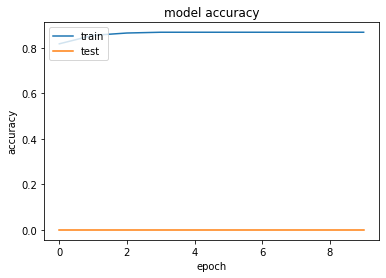

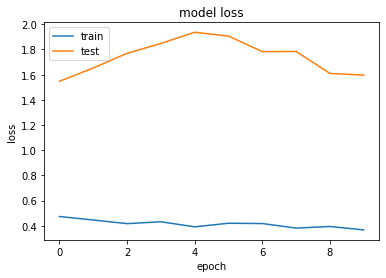

In [ ]:
_, sequence_model1 = exp_run1()

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.8678
Epoch 1: val_loss improved from inf to 1.73137, saving model to /content/video_classifier
10/10 [==============================] - 11s 360ms/step - loss: 0.4390 - accuracy: 0.8678 - val_loss: 1.7314 - val_accuracy: 0.0000e+00
Epoch 2/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.3871 - accuracy: 0.8681
Epoch 2: val_loss improved from 1.73137 to 1.45617, saving model to /content/video_classifier
10/10 [==============================] - 1s 61ms/step - loss: 0.3843 - accuracy: 0.8678 - val_loss: 1.4562 - val_accuracy: 0.0000e+00
Epoch 3/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.3233 - accuracy: 0.8681
Epoch 3: val_loss improved from 1.45617 to 1.39957, saving model to /content/video_classifier
10/10 [==============================] - 1s 63ms/step - loss: 0.3232 - accuracy: 0.8678 - val_loss: 1.3996 - val_accuracy: 0.0000e+00
Epoch 4/10
 9/10 [==================

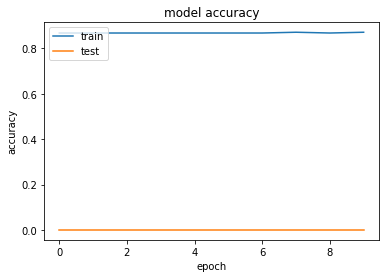

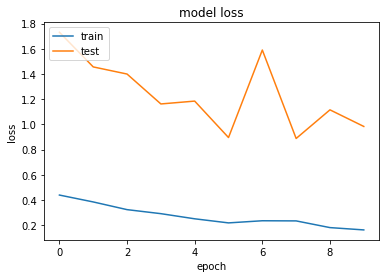

In [ ]:
_, sequence_model2 = exp_run2()

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.7746 - accuracy: 0.4641
Epoch 1: val_loss improved from inf to 0.71411, saving model to /content/video_classifier
6/6 [==============================] - 3s 202ms/step - loss: 0.7746 - accuracy: 0.4641 - val_loss: 0.7141 - val_accuracy: 0.4231
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.4475
Epoch 2: val_loss improved from 0.71411 to 0.70059, saving model to /content/video_classifier
6/6 [==============================] - 0s 75ms/step - loss: 0.7446 - accuracy: 0.4475 - val_loss: 0.7006 - val_accuracy: 0.4231
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.4475
Epoch 3: val_loss improved from 0.70059 to 0.69336, saving model to /content/video_classifier
6/6 [==============================] - 0s 78ms/step - loss: 0.7299 - accuracy: 0.4475 - val_loss: 0.6934 - val_accuracy: 0.4231
Epoch 4/10
6/6 [==============================] - ETA: 0s - l

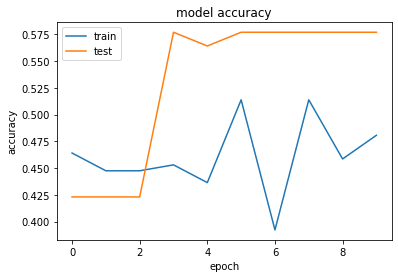

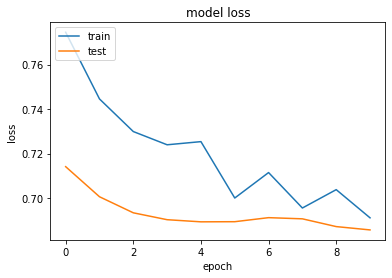

In [ ]:
_, sequence_model3 = run_experiment3()